# MNIST - CNN (tensorflow)

### Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

from sklearn.utils import shuffle

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
train_xdata = np.array([np.reshape(x, (28, 28, 1)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28, 28, 1)) for x in mnist.test.images])
train_labels = mnist.train.labels
test_labels = mnist.test.labels

C:\Users\jeeyeon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [2]:
print(train_xdata.shape, test_xdata.shape, train_labels.shape, test_labels.shape)

(55000, 28, 28, 1) (10000, 28, 28, 1) (55000, 10) (10000, 10)


### Layer

##### (1) Input layer

In [3]:
input_data = tf.placeholder(tf.float32, shape = [None, 28, 28, 1])

# 흑백 이미지 데이터. 따라서 channel = 1
# training 방법으로 mini-batch 선택. 따라서 input data의 데이터 수가 batch size에 dependent하기 때문에 [None, 28, 28, 1]로 지정.

##### (2) Convolution layer 1

In [4]:
FW1 = 4
FH1 = 4
FN1 = 32

filter1 = tf.Variable(tf.random_normal([FW1, FH1, 1, FN1], mean = 0, stddev = 0.1))
bias1 = tf.Variable(tf.zeros([1, 1, FN1]))
# cross entropy를 최소화하는 filter1과 bias1을 찾는 것이 목표이기 때문에 filter1과 bias1 값을 바꿔가면서 optimizing.
# output의 차원 유지를 위해 [4, 4, 1] 크기의 filter를 32개 생성.

conv1 = tf.nn.conv2d(input_data, filter1, strides = [1, 1, 1, 1], padding = "SAME")
relu1 = tf.nn.relu(conv1 + bias1)
# input_data & filter : 2차원에서 filter1을 한 칸씩 옮기면서 element-wise operation. 단, 차원 유지를 위해 padding = "SAME" 옵션 설정.
# conv1.shape = relu1.shape = [None, 28, 28, 32]

max_pool1 = tf.nn.max_pool(relu1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
# 중복되는 정보를 제거하기 위해 (overfitting 방지하기 위해) pooling.
# 2 by 2 windows로 pooling. window size와 strides를 동일하게 맞춰주어야 한다.
# max_pool1.shape = [None, 14, 14, 32]

##### (3) Convolution layer 2

In [5]:
FW2 = 4
FH2 = 4
FN2 = 64

filter2 = tf.Variable(tf.random_normal([FW2, FH2, FN1, FN2], mean = 0, stddev = 0.1))
bias2 = tf.Variable(tf.zeros([1, 1, FN2]))
# cross entropy를 최소화하는 filter2와 bias2를 찾는 것이 목표이기 때문에 filter2와 bias2 값을 바꿔가면서 optimizing.
# output의 차원 유지를 위해 [4, 4, 1] 크기의 filter를 64개 생성.

conv2 = tf.nn.conv2d(max_pool1, filter2, strides = [1, 1, 1, 1], padding = "SAME")
relu2 = tf.nn.relu(conv2 + bias2)
# convolution layer 2에서 input_data : max_pool1
# max_pool1 & filter : 2차원에서 filter2를 한 칸씩 옮기면서 element-wise operation. 단, 차원 유지를 위해 padding = "SAME" 옵션 설정.
# conv2.shape = relu2.shape = [None, 14, 14, 64]

max_pool2 = tf.nn.max_pool(relu2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
# 중복되는 정보를 제거하기 위해 (overfitting 방지하기 위해) pooling.
# 2 by 2 windows로 pooling. window size와 strides를 동일하게 맞춰주어야 한다.
# max_pool2.shape = [None, 7, 7, 64]

##### (4) Reshape

In [6]:
# Affine layer, 즉, Deep Neural Network를 실행하기 위해서 2차원으로 차원 변환 과정 필요.
# convolution layer 2에서 출력된 최종 output의 shape = max_pool2.shape = [None, 7, 7, 64]
# [None, 7, 7, 64] -> [None, 7 * 7 * 64]로 reshape.

final_conv_shape = max_pool2.get_shape().as_list()
final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
flat_output = tf.reshape(max_pool2, [-1, final_shape])
# [-1, final_shape]에서 -1 의미 : batch size 유지.

##### (5) Affine layer

In [7]:
W1 = tf.Variable(tf.random_normal([final_shape, 128], mean = 0, stddev = 0.001))
b1 = tf.Variable(tf.zeros([1, 128]))
# affine layer에서 input_data : flat_output
# flat_output.shape = [None, 7 * 7 * 64]
# W1.shape = [7 * 7 * 64, 128]
# b1.shape = [1, 128]
# cross entropy를 최소화하는 W1과 b1을 찾는 것이 목표이기 때문에 W1과 b1 값을 바꿔가면서 optimizing.

a1 = tf.nn.relu(tf.matmul(flat_output, W1) + b1)
# b1은 [1, 128]에서 [None, 128]로 broadcasting이 된 후, 위의 연산 과정을 거쳐 a1이 출력된다.
# a1.shape = [None, 128]

##### (6) Dropout

In [8]:
keep_prob = tf.placeholder(tf.float32)
a1_drop = tf.nn.dropout(a1, keep_prob)

##### (7) Output layer

In [9]:
W2 = tf.Variable(tf.random_normal([128, 10], mean = 0, stddev = 0.001))
b2 = tf.Variable(tf.zeros([1, 10]))
# output layer에서 input_data : a1_drop
# a1.shape = [None, 128]
# W2.shape = [128, 10]
# b2.shape = [1, 10]
# cross entropy를 최소화하는 W2와 b2를 찾는 것이 목표이기 때문에 W2와 b2 값을 바꿔가면서 optimizing.

a2 = tf.nn.softmax(tf.matmul(a1_drop, W2) + b2)
# b2는 [1, 10]에서 [None, 128]로 broadcasting이 된 후, 위의 연산 과정을 거쳐 a2가 출력된다.
# a2.shape = [None, 10]
# 10개의 class로 분류하기 위해 softmax 함수 사용.

t = tf.placeholder(tf.float32, shape = [None, 10])
# t : true label (true y)
# training 방법으로 mini-batch 선택. 따라서 output의 데이터 수가 batch size에 dependent하기 때문에 [None, 10]으로 지정.

### Initializing

In [10]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

### Cross entropy & Train step & accuracy

In [11]:
cross_entropy = tf.reduce_mean(-tf.reduce_mean(t * tf.log(a2), axis = 1))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)
# t.shape = [None, 10]
# a2.shape = [None, 10]
# t & a2 : 각 행마다 element-wise operation 후, 평균을 취해주면 shape가 [None, 1]이 되고 다시 한 번 평균을 취해주면 scalar가 된다.
# learning rate는 0.1로 설정 후, Stochastic Gradient Descent 방법으로 cross entropy가 최소가 되게끔 optimizing.

correct_prediction = tf.equal(tf.argmax(t, 1), tf.argmax(a2, 1))
# true label인 t의 각 행에서 가장 큰 값의 위치와 output인 a2의 각 행에서 가장 큰값의 위치가 일치하는지 체크.
# 즉, 실제값과 예측치가 일치하는지 true/false로 반환해준다.

accuracy = tf.reduce_mean(tf.to_float(correct_prediction))
# true/false로 이루어진 correct_prediction을 숫자로 바꾸면 true는 1로 false는 0으로 바뀐다.
# 이렇게 0과 1로 바뀐 숫자들의 평균 = 예측 정확도

### Training (mini-batch)

In [ ]:
batch_size = 100
n_batch = 55000 // batch_size

for epoch in range(10) :
    X_, Y_ = shuffle(train_xdata, train_labels)
    
    for i in range(n_batch) :
        start = 0 + i * batch_size
        end = start + batch_size
        sess.run(train_step, feed_dict = {input_data : X_[start:end, :], t : Y_[start:end, :], keep_prob : 0.8})
        
# mini-batch 방식으로 training.
# train data를 100개씩 550번 training 하는데 이 과정을 총 10번 반복.
# 매 epoch마다 train data 100개를 random하게 추출해서 550번 training하기 위해 train data를 shuffle.
# 20% 확률의 dropout 이용.

### Result

##### (1) Accuracy

In [ ]:
train_acc = sess.run(accuracy, feed_dict = {input_data : train_xdata, t : train_labels, keep_prob : 0.8})
test_acc = sess.run(accuracy, feed_dict = {input_data : test_xdata, t : test_labels, keep_prob : 1.0}) #dropout off
print(train_acc, test_acc)

##### (2) Misclassification

In [15]:
b = sess.run(correct_prediction, feed_dict = {input_data : test_xdata, t : test_labels, keep_prob : 1.0})
# training으로부터 구해진 variable을 이용해 test data를 입력했을 때의 예측치가 실제값과 일치하는지 true/false를 반환.

index = np.where(b == False)
index
# 예측치와 실제값이 불일치하는 행. 즉, misclassification index.

(array([ 247,  259,  290,  320,  321,  340,  445,  495,  582,  583,  591,
         613,  619,  659,  684,  720,  740,  938,  947,  965, 1014, 1039,
        1112, 1114, 1181, 1182, 1226, 1232, 1247, 1260, 1290, 1299, 1319,
        1326, 1378, 1393, 1414, 1500, 1522, 1530, 1553, 1621, 1678, 1681,
        1709, 1717, 1754, 1790, 1878, 1901, 1984, 2016, 2035, 2043, 2044,
        2053, 2093, 2098, 2109, 2129, 2130, 2135, 2148, 2182, 2185, 2189,
        2272, 2293, 2387, 2406, 2408, 2414, 2422, 2433, 2447, 2462, 2488,
        2607, 2631, 2648, 2654, 2771, 2863, 2896, 2927, 2952, 2953, 2995,
        3005, 3060, 3073, 3206, 3503, 3520, 3550, 3558, 3597, 3629, 3662,
        3718, 3757, 3767, 3780, 3796, 3808, 3818, 3836, 3838, 3869, 3902,
        3906, 3926, 3941, 3943, 3985, 4065, 4075, 4078, 4152, 4163, 4176,
        4224, 4248, 4256, 4289, 4306, 4435, 4477, 4497, 4500, 4536, 4575,
        4578, 4601, 4639, 4740, 4761, 4807, 4814, 4823, 4874, 4880, 4956,
        4966, 5159, 5331, 5600, 5642, 

In [16]:
actual_my = np.argmax(test_labels, axis = 1)
# actual_my : 실제값

pred_my = sess.run(tf.argmax(a2, 1), feed_dict = {input_data : test_xdata, keep_prob : 1.0})
# pred_my : 예측치

In [17]:
actual_my[index[0]]
# 잘못 분류한 행에 해당되는 실제값

array([4, 6, 8, 9, 2, 5, 6, 8, 8, 2, 8, 2, 1, 2, 7, 5, 4, 3, 8, 6, 6, 7,
       4, 3, 6, 6, 7, 9, 9, 7, 3, 5, 8, 7, 5, 5, 9, 7, 7, 8, 9, 0, 2, 3,
       9, 8, 7, 2, 8, 9, 2, 7, 5, 4, 2, 4, 8, 2, 3, 9, 4, 6, 4, 1, 0, 9,
       8, 9, 9, 9, 3, 9, 6, 2, 4, 2, 2, 7, 0, 9, 6, 4, 9, 8, 3, 3, 3, 6,
       9, 9, 1, 8, 9, 6, 6, 5, 9, 8, 8, 4, 8, 7, 4, 2, 7, 0, 7, 7, 9, 5,
       1, 9, 4, 3, 9, 0, 8, 9, 5, 9, 2, 9, 2, 3, 2, 3, 3, 0, 8, 9, 6, 4,
       7, 8, 8, 3, 9, 8, 6, 9, 9, 0, 8, 7, 4, 1, 7, 1, 3, 7, 4, 7, 4, 5,
       5, 3, 3, 5, 5, 2, 3, 3, 3, 9, 9, 9, 9, 9, 9, 9, 8, 9, 0, 9, 0, 6,
       4, 9, 2, 2, 2, 2, 3, 8, 8, 4, 7, 7, 7, 8, 9, 9, 0, 9, 2, 6, 9, 2,
       5, 5, 8, 4, 5, 2, 5, 2, 2, 2, 6, 8, 3, 3, 5], dtype=int64)

In [18]:
pred_my[index[0]]
# 잘못 분류한 행에 해당되는 예측치

array([2, 0, 4, 1, 7, 3, 0, 0, 2, 7, 3, 8, 8, 1, 3, 8, 9, 5, 9, 0, 5, 1,
       6, 8, 1, 8, 2, 4, 0, 1, 5, 7, 3, 2, 6, 3, 7, 1, 9, 7, 3, 6, 0, 7,
       5, 0, 2, 8, 3, 4, 0, 2, 3, 8, 7, 9, 1, 0, 7, 8, 9, 1, 9, 2, 8, 1,
       0, 0, 1, 1, 9, 4, 4, 1, 9, 8, 4, 1, 6, 0, 1, 9, 4, 0, 2, 5, 5, 5,
       1, 7, 2, 3, 1, 4, 5, 0, 3, 3, 0, 9, 3, 2, 6, 8, 8, 6, 9, 1, 4, 3,
       3, 3, 2, 5, 4, 2, 0, 3, 1, 0, 7, 7, 8, 0, 7, 7, 7, 6, 7, 1, 5, 2,
       9, 4, 9, 5, 8, 0, 0, 4, 0, 8, 4, 9, 9, 6, 9, 8, 7, 9, 7, 0, 0, 3,
       3, 8, 8, 3, 8, 0, 9, 9, 8, 3, 3, 8, 8, 3, 8, 0, 9, 7, 7, 5, 8, 4,
       8, 5, 7, 4, 1, 8, 8, 5, 6, 9, 2, 2, 2, 5, 8, 4, 8, 7, 7, 3, 7, 8,
       0, 6, 1, 2, 6, 0, 0, 0, 8, 7, 0, 5, 9, 8, 6], dtype=int64)

### Plot

4 2
6 0
8 4
9 1
2 7
5 3
6 0
8 0
8 2
2 7
8 3
2 8


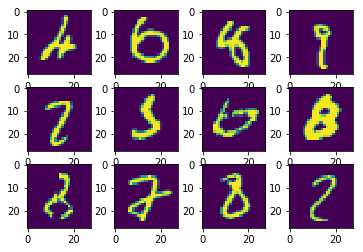

In [19]:
Nrow = 3
Ncol = 4

for i in range(Nrow * Ncol) :
    plt.subplot(Nrow, Ncol, i + 1)
    plt.imshow(test_xdata[index[0][i], :, :, 0])
    print(actual_my[index[0][i]], pred_my[index[0][i]])
    
# misclassification index를 이용해 잘못 분류한 처음 12개의 데이터에 대해서 실제값과 예측치를 print하고 그림 출력.